In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [4]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [5]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate(speckle_noise=True)
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_92.nc


## Adding ERA5

In [12]:
era5 = xr.open_dataset('/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/era5_winds/era5_wind_202011.nc')
era5

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 720)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-11-01 ... 2020-11-30T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-04 11:26:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [13]:
date = test.S1_file.azimuth_time.min().values.astype('datetime64[m]').astype(object)
date_rounded = round_to_hour(date)
time = np.datetime64(date_rounded, 'ns')

In [14]:
era5_subset_time = era5.sel(
    time = time,
    method = 'nearest')

era5_subset = era5_subset_time.sel(
    longitude = test.convert_to_0_360(test.S1_file.longitude),
    latitude = test.S1_file.latitude,
    method = 'nearest')

# ERA5 data is subsampled
# this should not affect resolution as, for example, the resolution of 1/4 deg ERA5 is approx 50km, 
# The resampled grid size should still be << 50km (S1 resolution * smoothing_window * undersample_factor << 50)
smoothing_window = 10
undersample_factor = 10
resolution_condition = test.resolution_spatial * undersample_factor * smoothing_window

# check whether resampling is unacceptable
# resolution is ideally twice the grid spacing
resolution_era5_deg = 2 * min([abs(era5.latitude.diff(dim = 'latitude')).min(), abs(era5.longitude.diff(dim = 'longitude')).min()])
# 1 degree is approximately 100km
resolution_era5_m = 100e3 * resolution_era5_deg 
message = "Warning: ERA5 resolution diminished by too much smoothing. \nConsider decreasing the resampling undersample factor or the window size."
if resolution_condition >= resolution_era5_m:
    print(message)

# create a placeholder dataset to avoid having to subsample/oversample on datetime vectors
azimuth_time_placeholder = np.arange(era5_subset.dims['azimuth_time'])
ground_range_placeholder = np.arange(era5_subset.dims['ground_range'])
era5_placeholder = era5_subset.assign_coords(azimuth_time=azimuth_time_placeholder, ground_range=ground_range_placeholder)

# Subsample the dataset by interpolation
new_azimuth_time = np.arange(era5_subset.dims['azimuth_time']/undersample_factor) * undersample_factor
new_ground_range = np.arange(era5_subset.dims['ground_range']/undersample_factor) * undersample_factor
era5_subsamp = era5_placeholder.interp(azimuth_time=new_azimuth_time, ground_range=new_ground_range, method='linear')

# first perform median filter (performs better if anomalies are present),then mean filter to smooth edges
era5_smoothed = era5_subsamp.rolling(azimuth_time = smoothing_window, ground_range = smoothing_window, center = True, min_periods=2).median()
era5_smoothed = era5_smoothed.rolling(azimuth_time = smoothing_window, ground_range = smoothing_window, center = True, min_periods=2).mean()

# re-interpolate to the native resolution and add to object
era5_interp = era5_smoothed.interp(azimuth_time=azimuth_time_placeholder, ground_range=ground_range_placeholder, method='linear')
test.era5 = era5_interp.assign_coords(azimuth_time=era5_subset.azimuth_time, ground_range=era5_subset.ground_range)

In [15]:
# compute wind vector
wdir_era5 = np.rad2deg(np.arctan2(test.era5.u10, test.era5.v10))

# compute ground footprint direction
geodesic = pyproj.Geod(ellps='WGS84')
ground_dir, _, _ = geodesic.inv(test.S1_file.longitude[0, 0], test.S1_file.latitude[0, 0], test.S1_file.longitude[-1,0], test.S1_file.latitude[-1,0])

# compute directional difference between satelite and era5 wind direction
test.wdir_wrt_sensor = angular_difference(ground_dir, wdir_era5)

In [16]:
windfield = cmod5n_inverse(test.S1_file["NRCS_VV"].data, test.wdir_wrt_sensor.data, test.S1_file["inc"].data)
nrcs_db = 10*np.log10(test.S1_file.NRCS_VV)
condition = (nrcs_db.isnull()) | (test.S1_file.NRCS_VV == 0)
windfield = xr.where(condition, np.nan, windfield)
# windfield.plot(robust = True)

## Misc

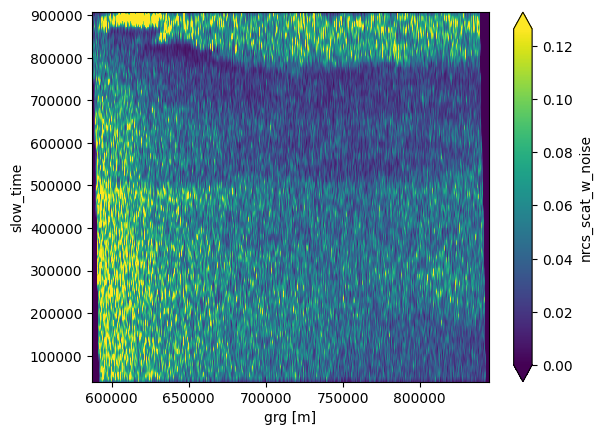

In [6]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.nrcs_scat_w_noise.T.plot(robust = True)

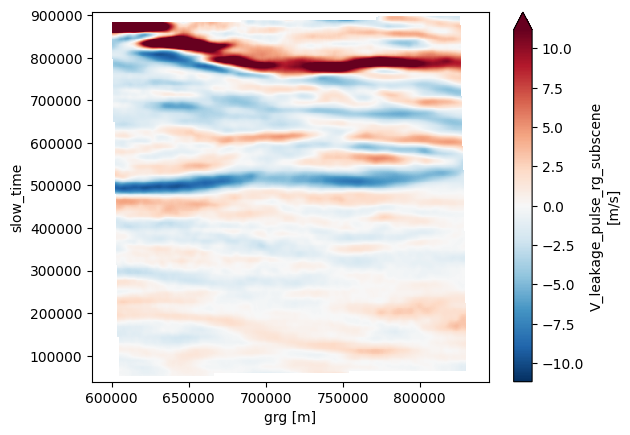

In [7]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.V_leakage_pulse_rg_subscene.T.plot(robust = True)

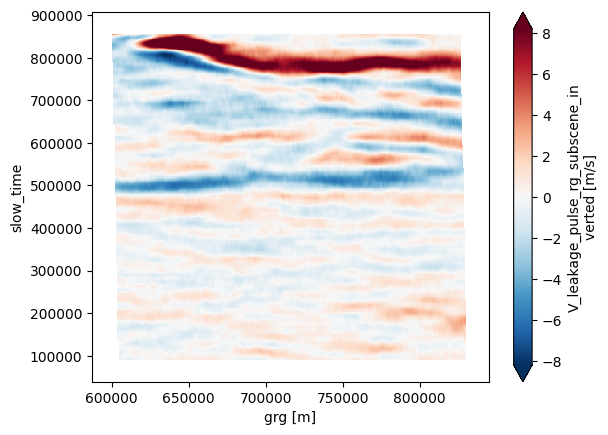

In [8]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.V_leakage_pulse_rg_subscene_inverted.T.plot(robust = True)

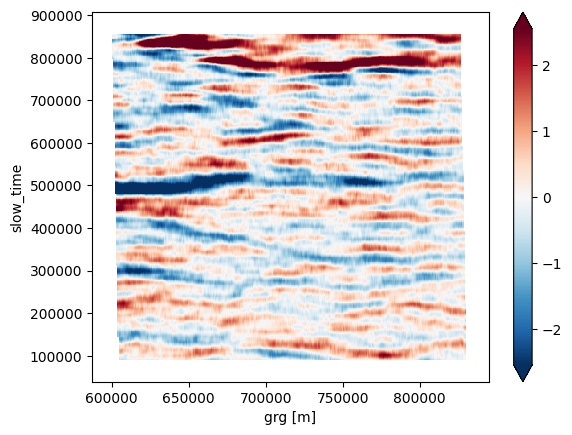

In [9]:
(test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted).T.plot(robust = True)